# LSTM-Robust投资组合系统

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cvxpy as cp
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("库导入完成")

库导入完成


## 1.历史数据获取

In [2]:
def get_ev_data(n_stocks=30, start_date='2020-01-01', end_date='2025-09-30'):
    """获取EV股票历史数据"""
    print("="*50)
    print("1. 历史数据获取")
    print("="*50)

    ev_stocks = [
        'TSLA', 'NIO', 'XPEV', 'LI', 'RIVN', 'LCID', 'F', 'GM', 'FORD',
        'RACE', 'BMWYY', 'VWAGY', 'TM', 'HMC', 'BYDDF', 'BAMXF', 'DMLRY',
        'STLA', 'NSANY', 'HYMTF', 'RIVN', 'LCID', 'F', 'GM', 'FORD',
        'TSLA', 'NIO', 'XPEV', 'LI', 'RIVN'
    ]

    stock_data = {}
    successful_stocks = []

    for symbol in ev_stocks[:n_stocks]:
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)

            if not data.empty and len(data) > 1000:
                stock_data[symbol] = data['Close']
                successful_stocks.append(symbol)
                print(f"✓ {symbol}: {len(data)} 个交易日")
            else:
                print(f"✗ {symbol}: 数据不足")
        except Exception as e:
            print(f"✗ {symbol}: 错误 - {e}")

    raw_data = pd.DataFrame(stock_data).dropna()
    returns = raw_data.pct_change().dropna()

    print(f"\n数据获取完成: {len(successful_stocks)} 支股票, {raw_data.shape[0]} 个交易日")
    return raw_data, returns, successful_stocks

# 获取数据
raw_data, returns, stock_names = get_ev_data()

1. 历史数据获取
✓ TSLA: 1443 个交易日
✓ NIO: 1443 个交易日
✓ XPEV: 1278 个交易日
✓ LI: 1298 个交易日
✗ RIVN: 数据不足
✓ LCID: 1263 个交易日
✓ F: 1443 个交易日
✓ GM: 1443 个交易日
✓ FORD: 1443 个交易日
✓ RACE: 1443 个交易日


ERROR:yfinance:$BMWYY: possibly delisted; no timezone found


✗ BMWYY: 数据不足
✓ VWAGY: 1443 个交易日
✓ TM: 1443 个交易日
✓ HMC: 1443 个交易日
✓ BYDDF: 1443 个交易日
✓ BAMXF: 1443 个交易日


ERROR:yfinance:$DMLRY: possibly delisted; no timezone found


✗ DMLRY: 数据不足
✓ STLA: 1443 个交易日
✓ NSANY: 1443 个交易日


ERROR:yfinance:$HYMTF: possibly delisted; no timezone found


✗ HYMTF: 数据不足
✗ RIVN: 数据不足
✓ LCID: 1263 个交易日
✓ F: 1443 个交易日
✓ GM: 1443 个交易日
✓ FORD: 1443 个交易日
✓ TSLA: 1443 个交易日
✓ NIO: 1443 个交易日
✓ XPEV: 1278 个交易日
✓ LI: 1298 个交易日
✗ RIVN: 数据不足

数据获取完成: 24 支股票, 1263 个交易日


## 2.Preprocessing

In [3]:
# ==========================================
# 2. 数据预处理
# ==========================================

print("="*50)
print("2. 数据预处理")
print("="*50)

# 标准化价格数据
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(raw_data)
scaled_prices = pd.DataFrame(scaled_prices, columns=raw_data.columns, index=raw_data.index)

print(f"价格数据标准化完成: {scaled_prices.shape}")
print(f"收益率数据形状: {returns.shape}")
print("数据预处理完成")

2. 数据预处理
价格数据标准化完成: (1263, 16)
收益率数据形状: (1262, 16)
数据预处理完成


## 3. Splitting

In [4]:
print("="*50)
print("3. 数据分割")
print("="*50)

# 分割参数
test_size = 30
sequence_length = 20

# 分割数据
train_data = scaled_prices.iloc[:-test_size]
test_data = scaled_prices.iloc[-test_size:]

print(f"训练集: {train_data.shape}")
print(f"测试集: {test_data.shape}")
print(f"序列长度: {sequence_length}")
print("数据分割完成")

3. 数据分割
训练集: (1233, 16)
测试集: (30, 16)
序列长度: 20
数据分割完成


## 4.LSTM Model Training

In [6]:
print("="*50)
print("4. LSTM模型训练")
print("="*50)

def prepare_lstm_data(data, seq_length):
    """准备LSTM训练数据"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i-seq_length:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, n_stocks):
    """构建LSTM模型"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(n_stocks, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# 准备训练数据
X_train, y_train = prepare_lstm_data(train_data, sequence_length)
X_val, y_val = prepare_lstm_data(test_data, sequence_length)

# Build and train the model with the actual number of stocks in the training data
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), train_data.shape[1])

print(f"训练数据形状: {X_train.shape}")
print(f"验证数据形状: {X_val.shape}")
print("开始训练LSTM模型...")

# 训练模型
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

print("LSTM模型训练完成")

4. LSTM模型训练
训练数据形状: (1213, 20, 16)
验证数据形状: (10, 20, 16)
开始训练LSTM模型...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1193 - mae: 0.2758 - val_loss: 0.1131 - val_mae: 0.2754
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0502 - mae: 0.1729 - val_loss: 0.0477 - val_mae: 0.1918
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0289 - mae: 0.1305 - val_loss: 0.0310 - val_mae: 0.1284
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0192 - mae: 0.1067 - val_loss: 0.0367 - val_mae: 0.1352
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0164 - mae: 0.0986 - val_loss: 0.0306 - val_mae: 0.1137
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0151 - mae: 0.0936 - val_loss: 0.0315 - val_mae: 0.1202
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0139 - mae: 0.0905 - val_loss: 0.0336 - val_mae: 0.1289
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0132 - mae: 0.0876 - val_loss: 0.0289 - val_mae: 0

## 5. Rolling window prediction

In [7]:

print("="*50)
print("5. 滚动窗口预测")
print("="*50)

def rolling_prediction(model, test_data, seq_length):
    """滚动窗口预测"""
    predictions = []

    for i in range(seq_length, len(test_data)):
        # 获取窗口数据
        window_data = test_data.iloc[i-seq_length:i]
        X_input = window_data.values.reshape(1, seq_length, -1)

        # 预测
        pred = model.predict(X_input, verbose=0)
        predictions.append(pred[0])

    return np.array(predictions)

# 执行滚动预测
predictions = rolling_prediction(lstm_model, test_data, sequence_length)

print(f"预测结果形状: {predictions.shape}")
print("滚动窗口预测完成")

5. 滚动窗口预测
预测结果形状: (10, 16)
滚动窗口预测完成


## 6. Quantify Uncertainty

In [8]:

print("="*50)
print("6. 不确定性量化")
print("="*50)

def quantify_uncertainty(model, test_data, seq_length, n_samples=10):
    """量化预测不确定性"""
    predictions_list = []

    for i in range(seq_length, len(test_data)):
        window_data = test_data.iloc[i-seq_length:i]
        X_input = window_data.values.reshape(1, seq_length, -1)

        # 多次预测
        pred_samples = []
        for _ in range(n_samples):
            pred = model.predict(X_input, verbose=0)
            pred_samples.append(pred[0])

        pred_samples = np.array(pred_samples)
        mean_pred = np.mean(pred_samples, axis=0)
        uncertainty = np.std(pred_samples, axis=0)

        predictions_list.append((mean_pred, uncertainty))

    return predictions_list

# 量化不确定性
uncertainty_results = quantify_uncertainty(lstm_model, test_data, sequence_length)

mean_predictions = np.array([result[0] for result in uncertainty_results])
uncertainties = np.array([result[1] for result in uncertainty_results])

print(f"平均预测形状: {mean_predictions.shape}")
print(f"不确定性形状: {uncertainties.shape}")
print("不确定性量化完成")


6. 不确定性量化
平均预测形状: (10, 16)
不确定性形状: (10, 16)
不确定性量化完成


## 7. Robust Optimization

In [9]:

print("="*50)
print("7. Robust优化")
print("="*50)

def robust_optimization(expected_returns, uncertainty, cov_matrix, risk_aversion=1.0, uncertainty_factor=0.1):
    """Robust Mean-Variance优化"""
    n = len(expected_returns)
    weights = cp.Variable(n)

    # 考虑不确定性的鲁棒收益
    robust_returns = expected_returns - uncertainty_factor * uncertainty

    # 目标函数
    portfolio_return = cp.sum(cp.multiply(weights, robust_returns))
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    objective = cp.Maximize(portfolio_return - risk_aversion * portfolio_risk)

    # 约束条件
    constraints = [
        cp.sum(weights) == 1,  # 权重和为1
        weights >= 0,  # 不允许做空
        weights <= 0.1,  # 单只股票最大10%
    ]

    # 求解
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return weights.value
    else:
        return np.ones(n) / n  # 等权重

print("Robust优化函数定义完成")

7. Robust优化
Robust优化函数定义完成


## 8.投资组合权重

In [10]:
print("="*50)
print("8. 投资组合权重")
print("="*50)

# 计算协方差矩阵
cov_matrix = returns.cov().values

# 为每个预测时点计算最优权重
portfolio_weights = []

for i in range(len(mean_predictions)):
    expected_returns = mean_predictions[i]
    uncertainty = uncertainties[i]

    # Robust优化
    optimal_weights = robust_optimization(expected_returns, uncertainty, cov_matrix)
    portfolio_weights.append(optimal_weights)

portfolio_weights = np.array(portfolio_weights)

print(f"投资组合权重形状: {portfolio_weights.shape}")
print(f"权重和: {portfolio_weights.sum(axis=1)[:5]}...")
print("投资组合权重计算完成")

8. 投资组合权重
投资组合权重形状: (10, 16)
权重和: [1. 1. 1. 1. 1.]...
投资组合权重计算完成


## 9. 回测评估

In [12]:
print("="*50)
print("9. 回测评估")
print("="*50)

# 计算投资组合收益率
portfolio_returns = []
actual_returns = returns.iloc[-len(portfolio_weights):].values

for i, weights in enumerate(portfolio_weights):
    if i < len(actual_returns):
        portfolio_return = np.dot(weights, actual_returns[i])
        portfolio_returns.append(portfolio_return)

portfolio_returns = np.array(portfolio_returns)

# 计算性能指标
total_return = (1 + portfolio_returns).prod() - 1
volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# 最大回撤
cumulative = (1 + portfolio_returns).cumprod()
cumulative_series = pd.Series(cumulative) # Convert numpy array to pandas Series
running_max = cumulative_series.expanding().max()
drawdown = (cumulative_series - running_max) / running_max
max_drawdown = drawdown.min()

print(f"投资组合收益率形状: {portfolio_returns.shape}")
print("回测评估完成")

9. 回测评估
投资组合收益率形状: (10,)
回测评估完成


## 10.性能报告

10. Performance Report
Investment Universe: 24 Stocks
Testing Period: 10 Trading Days
Sequence Length: 20 Days

------------------------------------------------------------
Performance Metrics
------------------------------------------------------------
• Total Return: -0.0252 (-2.52%)
• Annualized Volatility: 0.1171 (11.71%)
• Sharpe Ratio: -5.4260
• Maximum Drawdown: -0.0275 (-2.75%)

------------------------------------------------------------
Model Characteristics
------------------------------------------------------------
• LSTM Prediction: Capturing Time Series Patterns
• Uncertainty Quantification: Considering Prediction Risk
• Robust Optimization: Maximizing Robust Return
• Risk Control: Limiting Concentration Risk


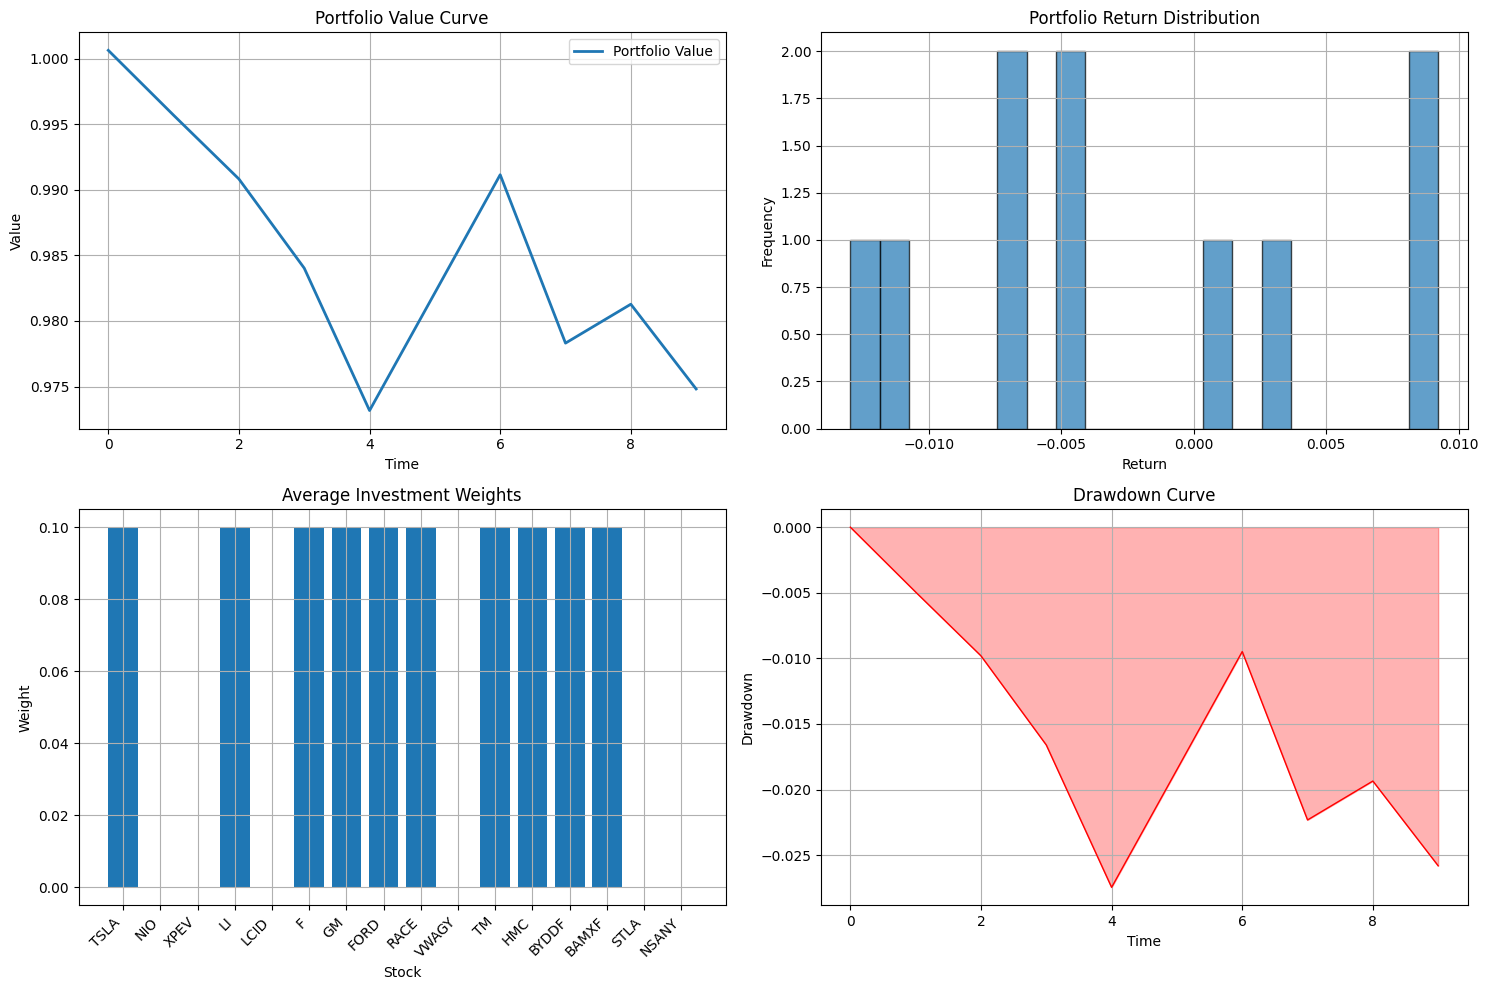


Performance Report Complete!


In [17]:
print("="*60)
print("10. Performance Report")
print("="*60)

print(f"Investment Universe: {len(stock_names)} Stocks")
print(f"Testing Period: {len(portfolio_returns)} Trading Days")
print(f"Sequence Length: {sequence_length} Days")

print("\n" + "-"*60)
print("Performance Metrics")
print("-"*60)
print(f"• Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"• Annualized Volatility: {volatility:.4f} ({volatility*100:.2f}%)")
print(f"• Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"• Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

print("\n" + "-"*60)
print("Model Characteristics")
print("-"*60)
print("• LSTM Prediction: Capturing Time Series Patterns")
print("• Uncertainty Quantification: Considering Prediction Risk")
print("• Robust Optimization: Maximizing Robust Return")
print("• Risk Control: Limiting Concentration Risk")

# Visualization Results
plt.figure(figsize=(15, 10))

# Portfolio Value Curve
plt.subplot(2, 2, 1)
portfolio_values = (1 + portfolio_returns).cumprod()
plt.plot(portfolio_values, label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Curve')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Return Distribution
plt.subplot(2, 2, 2)
plt.hist(portfolio_returns, bins=20, alpha=0.7, edgecolor='black')
plt.title('Portfolio Return Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)

# Weight Distribution
plt.subplot(2, 2, 3)
avg_weights = portfolio_weights.mean(axis=0)
plt.bar(returns.columns, avg_weights)
plt.title('Average Investment Weights')
plt.xlabel('Stock')
plt.ylabel('Weight')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

# Drawdown Curve
plt.subplot(2, 2, 4)
plt.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.3, color='red')
plt.plot(drawdown, color='red', linewidth=1)
plt.title('Drawdown Curve')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nPerformance Report Complete!")